## KNN(K-Nearest Neighborhood)

### Kütüphanelerin Dahil Edilmesi
Programımız içerisinde gerekli işlemler için bazı kütüphanelerden yararlandım

In [1]:
# Importing the libraies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,classification_report
from sklearn.preprocessing import LabelEncoder

from collections import Counter

### Global Değişkenlerin Tanımlanması
Bu kısımda bazı değişkenlere her fonksiyondan erişebilmek için bu değişkenleri global olarak tanımladım .

In [2]:
# Global variables
X,Y=[],[]
X_train, X_test, Y_train, Y_test=[],[],[],[]

### Class Label'ın ayrılması
Bu fonksiyonumda elimizdeki dataframe üzerindeki class label'a ait olan sütunu kullanıcıdan alarak Y diye adlandırdığımız değişkene ve kalan sütunları ise X değişkenine atadık . Eğer girilen değer sütunlarda yoksa hata mesajı döndürdük .

In [3]:
def seperateXY(df):
    # Seperating our data to X and Y arrays
    while True:
        global X,Y
        classLabel = input("\nWrite the class label : ")
        if classLabel in df.columns:
            X = df.drop(classLabel, axis=1)
            Y = df[classLabel]
            break
        else:
            print(f"\"{classLabel}\" class label is unknown.")

### Encode işlemi
Bu kısımda yaptığım işlem algoritmamızın kategorik veriler için de uygulanabilir olmasını sağlamaktır . Bunun için sayısal olmayan verileri bulup bu verilerimizi LabelEncoder ile sayısal verilere çevirmiş olduk .

In [4]:
def encodeLabels():
    
    # Find the categorical values
    df_categorical = X.select_dtypes(include = 'object')
    
    le = LabelEncoder()
    for col in df_categorical.columns.values:
        X[col] = le.fit_transform(X[col])
    print(X.head)

### Sütunların Düzenlenmesi
Bu kısımdaki fonksiyonumda kullanıcının istemediği sütunları kaldırmasına olanak sağladım . While True döngüsü içerisinde F değeri girilene kadar işlem yapılmasını belirttim .

In [5]:
def prepareColumns():
    global X
    columnlist = list(X.columns.values)
    i=0
    cdict = {}
    
    for column in columnlist:
        cdict[i] = column
        i=i+1
    
    while(True):
        print("\nPress enter after typing the column which you don't want to add prediction")
        printColumns(cdict)
        print("If you have finished enter the letter 'F' ")
        choice = input("\n=> ")
        
        if choice == "F" or choice =="f":
            break
        elif int(choice) in cdict:
            del X[cdict[int(choice)]]
            del cdict[int(choice)]
        else:
            print("You pressed an incorrect key !\n")

Üst kısımda yazmış olduğum fonksiyonda oluşturmuş olduğum dictionary tipindeki değişkenimde tuttuğum indeksler ve sütunların isimlerini yazdırmak için aşağıdaki fonksiyonu kullandım

In [6]:
def printColumns(cdict):
    # Print their indexes and column names
    for number in cdict:
        print(str(number)+"."+cdict[number])

### Uzaklıkların Bulunması
Uzaklıkları bulmak için çeşitli yöntemler vardır . Euclidian , Manhattan ve Minkowski bunlara örnek gösterilebilir . Ben kendi programımda Manhattan yöntemini de kapsadığı , onun bir genel formülü formunda olmasından ötürü Minkowski yöntemini tercih ettim . 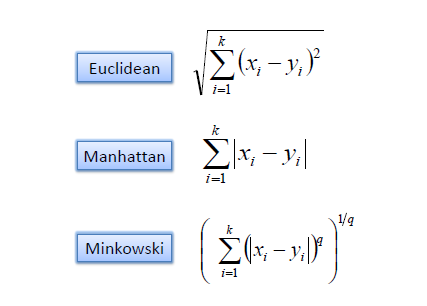

In [7]:
def minkowski_distance(p1, p2, p=1):
    
    dimensions = len(p1) # or p2 , it doesn't matter
    totalDistance = 0
    
    for d in range(dimensions):
        
        # Minkowski distance formula

        #   _  __          p   _ 1/p
        #  |   \   |x - y|     |   
        #  |_  /_    i   i    _| 
        #
        
        totalDistance += abs(p1[d] - p2[d])**p
        
    totalDistance = totalDistance**(1/p)
    return totalDistance

### X'in Ölçeklenmesi
Şimdi bir hayal edelim , yaş ve gelir bilgileri içeren bir veri setimiz var ve bu veri setimizi KNN algoritması ile çalıştıracağız . 

KNN in yaş ve maaş verilerinden aldığı uzaklık bilgilerinin büyüklüğü çok fazla ve fazla değişken olacak ve bu yüzden gelire nazaran daha az bi değer olan yaş değerimiz algoritma için pek de bir anlam ifade etmeyecektir .

Çözüm olarak bu değerlerin hepsini belirli bir aralığa dizmemiz algoritmamız için çok daha iyi olacaktır . Bunu yapmak için de bu fonksiyon içinde bir min max scaler kullanıp X_train ve X_test verilerime uyguladım .

In [8]:
def MinMaxNormalization(data, new_min=0, new_max=1):
    old_min = np.min(data, axis=0)
    old_max = np.max(data, axis=0)
    denominator = abs(old_max - old_min)
    
    return (np.divide((data - old_min), denominator) * ( new_max - new_min ) + new_min)

### Tahmin işleminin yapılması
Nihai amacımız olan girilen verinin class label'ının tahmin edilmesi işlemi aşağıda görmüş olduğunuz fonksiyon içerisinde yapılmaktadır . Bu fonksiyon k ve p değerleri almaktadır . Veri setimiz içersindeki her sample , bizim gönderdiğimiz veri ile kıyaslanır ve bir uzaklık değeri oluşturur . Bunlar "distancesDF" adlı dataframe de verilerin indeks sırasına göre tutulur . Ardından uzaklıklara göre sıralama işlemi yapılır ve içlerinden en üstte bulunan k tanesi seçilir . Counter adlı kütüphane ile birlikte bu verileri class label a göre gruplayabiliyoruz . İlk köşeli parantez output sayınıza göre değişir fakat en çok olan 0. indekste olduğu için biz o indeksi seçtik . counter.most_common()[0] haliyle bıraksaydık K değerimiz de 10 olsaydı  çıktımız şu şekilde olabilirdi :

(0,7) 

Burada ilk değerimiz class label , ikinci değer ise k değer (10) içerisinde o değerden kaç tane komşusu olduğudur . O yüzden bir köşeli parantez daha ekleyip 0. indeksini aldık .

In [9]:
def predict(X_test,k, p):
    global X_train,Y_train
    predictions=[]
    
    for test_point in X_test.values:
        distances = []
        
        for train_point in X_train.values:
            
            distance = minkowski_distance(test_point, train_point, p=p)
            distances.append(distance)
        
        distancesDF = pd.DataFrame(data=distances, columns=['dist'], 
                                index=Y_train.index)
        
        n_neighboors = distancesDF.sort_values(by=['dist'], axis=0)[:k]

        counter = Counter(Y_train[n_neighboors.index])

        prediction = counter.most_common()[0][0]
        
        predictions.append(prediction)
    
    return predictions

### En iyi K değerinin bulunması
Burada fonksiyona bakmasını istediğimiz minimum ve maksimum k değerlerini giriyoruz . Ardından min/max k değerlerini kontrol ettikten sonra sırayla aralıktaki k değerlerini veri seti için test ediyor . En yüksek başarı oranını best_acc , k değerini ise best_k değişkenine atayıp bunları yazdırıyor . Son olarak da programım Başarı/K değeri grafiğini bastırıyor .

In [10]:
def findTheBestK(mink,maxk):
    global X_train, X_test, Y_train, Y_test
    best_acc=0
    best_k = 0
    accuracies = []
    
    if(mink <= 0):
        print("The minimum value of K cannot be less than 1 ! ")
        mink=1
        print("(New minimum value = 1)")
        
    if(maxk > (len(X_train)-1)):
        print("The maximum value of K cannot be higher than size of dataset")
        maxk=(len(X_train)-1)
        print("(New maximum value = "+str(maxk)+")")
        
    for k in tqdm(range(mink,maxk)):
        predictions = predict(X_test,k=k, p=1)
        acc=accuracy_score(Y_test, predictions);
        if(acc>best_acc):
            best_acc=acc
            best_k=k
        accuracies.append(accuracy_score(Y_test, predictions))

    print("\nBest acc = "+str(best_acc)+"\nBest k = "+str(best_k))
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(range(mink,maxk), accuracies)
    ax.set_xlabel('The k values')
    ax.set_ylabel('Accuracy (%)');

### Main Kısmı
Burada veri setimizi programa dahil edip gerekli fonksiyonları çağırdık . Haricinde oluşturmuş olduğum KNN sınıflandırıcının performansını Sklearn kütüphanesindeki KNN sınıflandırıcısı ile kıyaslayıp yakaladığım oranları kıyasladım . 

In [11]:
def main():
    global X_train, X_test, Y_train, Y_test
    global X,Y
    
    df = pd.read_csv('heart.csv') #heart.csv
    for col in df.columns: 
        print(col) 
    
    seperateXY(df)
    
    prepareColumns()
    
    encodeLabels()
    
    # Split the data - 75% train, 25% test
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20,random_state=42)
    
    # We use scaler because it's like a necessary at distance algorithms
    # If you use age and salary values in your dataset ,
    # their distances will be so different and We are using scaler
    # and changing their scale to small numbers with scalers
    
    X_train = MinMaxNormalization(X_train)
    X_test = MinMaxNormalization(X_test)
    
    k = int(input("\nInput a K value = "))
    p = int(input("Input a P value (Default 1) = "))
    
    predictions = predict(X_test,k=k, p=p)
    
    print("\n"+classification_report(Y_test,predictions))

    print(f"Our KNN Accuracy: {accuracy_score(Y_test, predictions)}")

    clf = KNeighborsClassifier(n_neighbors=k, p=p)
    clf.fit(X_train, Y_train)
    y_pred_test = clf.predict(X_test)

    print(f"Sklearn KNN Accuracy: {accuracy_score(Y_test, y_pred_test)}")
    
    answer = input("\nDo you want to get the best k value ? (Y/N)")
    
    if answer == "Y" or answer == "y":
        mink = int(input("Start value for k : "))
        maxk = int(input("End value for k : "))
        findTheBestK(mink,maxk)
    else :
        print("THE END")

Age
Sex
Degree of Chest Pain
Rest blood Pressure
Cholesterol
Fasting Plasma Glucose(More than 120mg/dl)
Resting Electrocardiographic Results
Max Heart Rate
Exercise Induced Angina
ST depression induced by exercise relative to rest
the Slope of the Peak
Number of Major Vessels
Type of Heart Defect
target

Write the class label : target

Press enter after typing the column which you don't want to add prediction
0.Age
1.Sex
2.Degree of Chest Pain
3.Rest blood Pressure
4.Cholesterol
5.Fasting Plasma Glucose(More than 120mg/dl)
6.Resting Electrocardiographic Results
7.Max Heart Rate
8.Exercise Induced Angina
9.ST depression induced by exercise relative to rest
10.the Slope of the Peak
11.Number of Major Vessels
12.Type of Heart Defect
If you have finished enter the letter 'F' 

=> F
<bound method NDFrame.head of      Age  Sex  Degree of Chest Pain  Rest blood Pressure  Cholesterol  \
0     63    1                     3                  145          233   
1     37    1                     2

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [01:55<00:00,  2.08it/s]



Best acc = 0.9016393442622951
Best k = 39


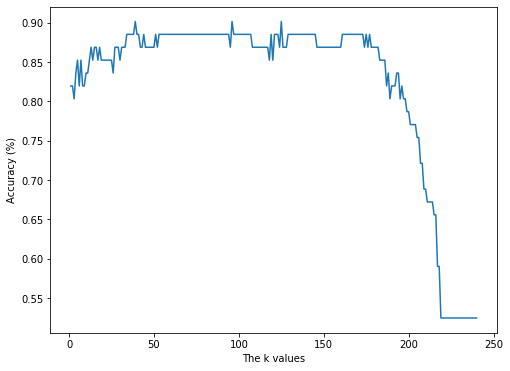

In [12]:
main()